In [27]:
# Library for data manipulation
import pandas as pd
import numpy as np

# Library for plotting
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns


# Library for Feature Engineering
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from scipy.stats import skew, kurtosis

# Library for data shuffle
from sklearn.utils import shuffle

# Library for fitting data
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Library for model evaluation
from sklearn.metrics import r2_score, mean_absolute_error

# Library to store Trained models (Temporary purpose)
import pickle
from datetime import timezone
import datetime

In [28]:
# Path to file
file_path = "/data/pp-complete.csv"

# Column names
columns = ["transaction_unique_id","sale_price","transfer_date","postcode","type","age","duration","paon","saon","street","locality","area","district","county","ppd_category","record_status"]

In [29]:
%%time

# Step: Import data (Assuming datatype as string to fasten the process of importing data because pandas takes lot of time to check the datatype)
data = pd.read_csv(file_path, 
                   names = columns,
                   encoding='utf-8',
                   skip_blank_lines=True,
                   dtype=str
                   )

# Step: Backup data
data_backup = data.copy()

CPU times: user 1.83 s, sys: 258 ms, total: 2.09 s
Wall time: 2.22 s


On a first glance,
- Need to check if there are missing values
- Need to change the data types of the corresponding columns (Sales Price, Transfer date, type)
- Need to split the transfer date into year and month
- Standardise the column values

There are no missing transactions

In [30]:
# Step: Check if any transaction with sale price is missing
data["sale_price"].isnull().sum()

0

In [31]:
# Step: Standardise the required column values to uppercase
data[['area','duration','type']] = data[['area','duration','type']].apply(lambda each_value: each_value.str.upper())

In [32]:
# Step: Convert sale_price datatype to floating point
data.sale_price = data.sale_price.astype('float')

The standard deviation of sale prices are in the range of $10^5$. This looks to be highly variable. 

In [33]:
# Step: Get statistical description of sale_price
data.sale_price.describe()

count    1.000000e+06
mean     6.872034e+04
std      6.085424e+04
min      1.000000e+00
25%      3.995000e+04
50%      5.500000e+04
75%      7.950000e+04
max      5.610000e+06
Name: sale_price, dtype: float64

In [34]:
# Step: Convert to datetime format 
data.transfer_date = pd.to_datetime(data.transfer_date)

In [35]:
# Step: Checking percentage of data with other property types 
(data[data.type == 'O'].shape[0] / data.shape[0]) * 100

0.0009

As there are less than 1.5% of data with other property, Its best to remove those data as they cannot significantly influence the outcome. 

In [36]:
# Step: Drop data with other property type
data.drop(data[data.type == 'O'].index, inplace=True)

In [37]:
# Step: Change data type of transfer_date to Datetime
data['transfer_date_converted'] = pd.to_datetime(data['transfer_date'], infer_datetime_format=True)

# Step: Extract datetime attribute(s) month name from 'transfer_date_converted'
data['transfer_date_converted_month_name'] = data['transfer_date_converted'].dt.month_name()

# Step: Extract datetime attribute(s) year from 'transfer_date_converted'
data['transfer_date_converted_year'] = data['transfer_date_converted'].dt.year

In [39]:
# Temporary data for plotting with specific years.
data_visualise = data[['sale_price','transfer_date_converted_year','area']]
data_visualise.transfer_date_converted_year.isin([1995,2005,2015,2022])

0          True
1          True
2          True
3          True
4          True
          ...  
999995    False
999996    False
999997    False
999998    False
999999    False
Name: transfer_date_converted_year, Length: 999991, dtype: bool

In [40]:
# Plotting to check sales price of different cities for 1995, 2005, 2015 and 2022
fig = px.line(data.sort_values(by=['transfer_date_converted_year'], ascending=[True]), x='transfer_date_converted_year', y='sale_price', color='area')
fig

In [42]:
# # Most popular houses in UK
# fig = px.violin(data_copy, x='type', y='sale_price')
# fig

In [43]:
# Temporary data for plotting having London area with property sales price more than 20000
data_london = data.loc[(data['area'].isin(['LONDON'])) & (data['sale_price'] > 20000)]

,transaction_unique_id,sale_price,transfer_date,postcode,type,age,duration,paon,saon,street,locality,area,district,county,ppd_category,record_status,transfer_date_converted,transfer_date_converted_month_name,transfer_date_converted_year
52,{7CE5A28F-36B0-4FCC-B69B-AF5A2E0D16AF},235000.0,1995-12-20,SW5 0NA,F,N,L,49,FLAT C,COURTFIELD GARDENS,LONDON,LONDON,KENSINGTON AND CHELSEA,GREATER LONDON,A,A,1995-12-20,December,1995
59,{8B04B267-2142-4ECE-B20F-B2E72D85FBB6},59950.0,1995-04-12,SE27 9PJ,T,N,F,16,NaN,HUBBARD ROAD,LONDON,LONDON,LAMBETH,GREATER LONDON,A,A,1995-04-12,April,1995
60,{E3DA03B2-CFD0-450A-95EB-B2E72F4F5B8D},150000.0,1995-01-12,N10 2HA,T,N,F,3,NaN,GOODWYNS VALE,LONDON,LONDON,BARNET,GREATER LONDON,A,A,1995-01-12,January,1995
90,{A340CF98-F6B1-4592-A27F-B69F778B82C6},54000.0,1995-08-18,E10 5DH,T,N,F,68,NaN,FARMER ROAD,LONDON,LONDON,WALTHAM FOREST,GREATER LONDON,A,A,1995-08-18,August,1995
96,{E7599919-4B36-422D-A3E0-B69FB479130D},195000.0,1995-09-15,W11 4JG,F,N,L,105B,NaN,CLARENDON ROAD,LONDON,LONDON,KENSINGTON AND CHELSEA,GREATER LONDON,A,A,1995-09-15,September,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
928,{19E76453-687F-49A1-9D83-B672F810A84D},78999.0,1995-07-28,N19 4BE,F,N,L,7,NaN,JUTLAND CLOSE,LONDON,LONDON,ISLINGTON,GREATER LONDON,A,A,1995-07-28,July,1995
935,{2CB4204D-6684-4348-9988-B2EF5C3DABC8},67000.0,1995-11-10,N2 8AS,F,N,L,25,NaN,KITCHENER ROAD,LONDON,LONDON,BARNET,GREATER LONDON,A,A,1995-11-10,November,1995
936,{1F8EC433-8C6F-4896-B1E8-B6731D80A3DB},80000.0,1995-09-01,N4 3BX,T,N,F,123,NaN,CORBYN STREET,LONDON,LONDON,ISLINGTON,GREATER LONDON,A,A,1995-09-01,September,1995
948,{67B841AC-55DF-43B5-B3CE-BDC3224C63A3},69500.0,1995-08-29,SW16 5AN,T,N,F,13,NaN,GRANTON ROAD,LONDON,LONDON,LAMBETH,GREATER LONDON,A,A,1995-08-29,August,1995


In [44]:
# Most popular houses in london
fig = px.box(data_london, x='type', y='sale_price')
fig

In [45]:
# Temporary data for plotting having london area based properties sold during the year 1995, 2005, 2015 and 2022
data_london_year = data_london.loc[data_london.transfer_date_converted_year.isin([1995,2005,2015,2022])]

data_london_year

,transaction_unique_id,sale_price,transfer_date,postcode,type,age,duration,paon,saon,street,locality,area,district,county,ppd_category,record_status,transfer_date_converted,transfer_date_converted_month_name,transfer_date_converted_year
52,{7CE5A28F-36B0-4FCC-B69B-AF5A2E0D16AF},235000.0,1995-12-20,SW5 0NA,F,N,L,49,FLAT C,COURTFIELD GARDENS,LONDON,LONDON,KENSINGTON AND CHELSEA,GREATER LONDON,A,A,1995-12-20,December,1995
59,{8B04B267-2142-4ECE-B20F-B2E72D85FBB6},59950.0,1995-04-12,SE27 9PJ,T,N,F,16,NaN,HUBBARD ROAD,LONDON,LONDON,LAMBETH,GREATER LONDON,A,A,1995-04-12,April,1995
60,{E3DA03B2-CFD0-450A-95EB-B2E72F4F5B8D},150000.0,1995-01-12,N10 2HA,T,N,F,3,NaN,GOODWYNS VALE,LONDON,LONDON,BARNET,GREATER LONDON,A,A,1995-01-12,January,1995
90,{A340CF98-F6B1-4592-A27F-B69F778B82C6},54000.0,1995-08-18,E10 5DH,T,N,F,68,NaN,FARMER ROAD,LONDON,LONDON,WALTHAM FOREST,GREATER LONDON,A,A,1995-08-18,August,1995
96,{E7599919-4B36-422D-A3E0-B69FB479130D},195000.0,1995-09-15,W11 4JG,F,N,L,105B,NaN,CLARENDON ROAD,LONDON,LONDON,KENSINGTON AND CHELSEA,GREATER LONDON,A,A,1995-09-15,September,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
928,{19E76453-687F-49A1-9D83-B672F810A84D},78999.0,1995-07-28,N19 4BE,F,N,L,7,NaN,JUTLAND CLOSE,LONDON,LONDON,ISLINGTON,GREATER LONDON,A,A,1995-07-28,July,1995
935,{2CB4204D-6684-4348-9988-B2EF5C3DABC8},67000.0,1995-11-10,N2 8AS,F,N,L,25,NaN,KITCHENER ROAD,LONDON,LONDON,BARNET,GREATER LONDON,A,A,1995-11-10,November,1995
936,{1F8EC433-8C6F-4896-B1E8-B6731D80A3DB},80000.0,1995-09-01,N4 3BX,T,N,F,123,NaN,CORBYN STREET,LONDON,LONDON,ISLINGTON,GREATER LONDON,A,A,1995-09-01,September,1995
948,{67B841AC-55DF-43B5-B3CE-BDC3224C63A3},69500.0,1995-08-29,SW16 5AN,T,N,F,13,NaN,GRANTON ROAD,LONDON,LONDON,LAMBETH,GREATER LONDON,A,A,1995-08-29,August,1995


In [46]:
# Plotting property sales prices in London for specific years
fig = px.line(data_london_year.sort_values(by=['transfer_date_converted_year'], ascending=[True]), x='transfer_date_converted_year', y='sale_price')
fig

In [47]:
# Step: Considering only specific column of interest
data = data[["sale_price","transfer_date_converted_year","type","duration","area"]]

In [48]:
# Step: Change data type of property type to Categorical/Factor
data['type_converted'] = data['type'].astype('category')

# Step: Change data type of duration to Categorical/Factor
data['duration_converted'] = data['duration'].astype('category')

,sale_price,transfer_date_converted,type,duration,area,type_converted,duration_converted
0,122000.0,1995-09-29,D,F,NOTTINGHAM,D,F
1,37000.0,1995-12-22,T,F,RUGBY,T,F
2,93500.0,1995-07-27,D,F,UXBRIDGE,D,F
3,32000.0,1995-03-03,T,F,BRIGHOUSE,T,F
4,38000.0,1995-09-08,T,F,BIRMINGHAM,T,F
...,...,...,...,...,...,...,...
999995,14750.0,1996-01-19,T,F,SUNDERLAND,T,F
999996,88000.0,1996-12-06,F,L,LONDON,F,L
999997,109500.0,1996-10-07,T,F,COBHAM,T,F
999998,48000.0,1996-07-22,S,F,YEOVIL,S,F


In [49]:
# Step: Drop raw column property type and duration and hold only those that have datatype converted
data.drop(['type','duration'],axis = 1, inplace=True)

#### Feature Engineering

Plan is to Encode all the columns to numerical. This will help the model to fit better.

In [58]:
# Step: Checking how many categories are there
for each_column in data.select_dtypes(include='category').keys().to_list():
    print(each_column, ':', len(data[each_column].unique()))

type_converted : 4
duration_converted : 3


We need to apply one-hot encoding on these multicategorical variables

In [65]:
# Step: Encoding the categorical columns
data_linear = pd.get_dummies(data, columns=data.select_dtypes(include='category').keys().to_list())

In [67]:
# Step: Checking the data count of area 
data_linear.area.value_counts().sort_values(ascending=False).head(20)

LONDON                 81055
MANCHESTER             14359
BRISTOL                14079
BIRMINGHAM             13984
NOTTINGHAM             12567
LEEDS                  10471
LIVERPOOL              10370
LEICESTER               9383
SOUTHAMPTON             8951
SHEFFIELD               8936
NORWICH                 6961
READING                 6787
STOKE-ON-TRENT          6641
NORTHAMPTON             6269
BRADFORD                5859
NEWCASTLE UPON TYNE     5791
CARDIFF                 5608
HULL                    5590
DERBY                   5551
COVENTRY                5417
Name: area, dtype: int64

In [80]:
# Step: Encoding area other than London to 0
data_linear.area.replace(list(data_linear.area.loc[~(data_linear.area == 'LONDON')].unique()), 0, inplace=True)


In [90]:
# Step: Encoding area London to 1
data_linear.area.replace('LONDON',1, inplace=True)

<AxesSubplot:>

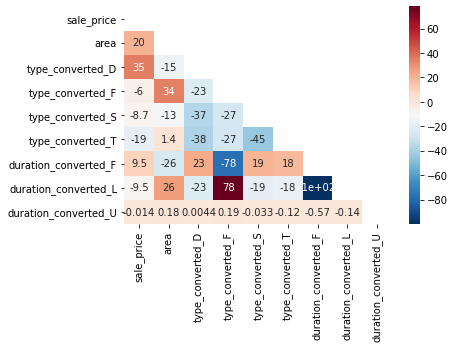

In [147]:
# Step: Correlation to check multicollinearity
mask = np.zeros_like(data_linear.corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True
# heatmap
sns.heatmap(data_linear.corr()*100, 
           cmap='RdBu_r', 
           annot = True, 
           mask = mask)

Need to check the data for skewness. This can influence the result of the model. We need to have Gaussian-like distribution.

In [95]:
# Step: Skewness
skew(data_linear.sale_price, bias=False)

11.661870771205933

The value suggests data is highly skewed. Next let's check if outliers are propogating this skewness.

In [97]:
# Step: Kurtosis
kurtosis(data_linear.sale_price, fisher=False)

494.01185795979154

The value is leptokurtic. Suggests we have heavy outliers.

In [143]:
# Step: Log transformation
np.log(data_linear.sale_price).skew()

-0.30590309875664146

After log transformation, It is still not exactly guassian

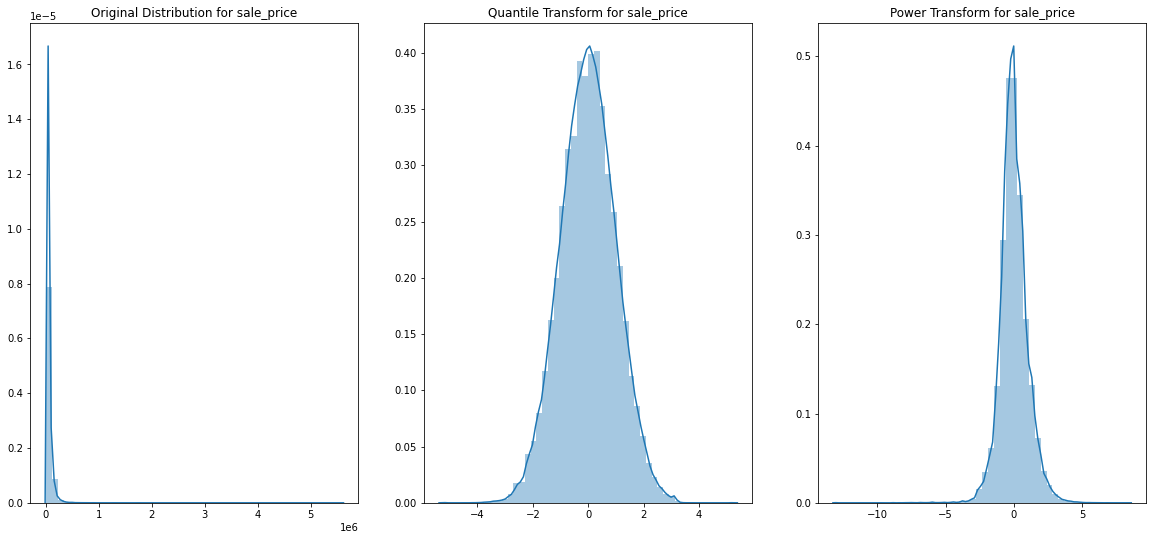

In [144]:


# Step: Applying numerical transformers 
pt = PowerTransformer()
qt = QuantileTransformer(output_distribution='normal')
plt.figure(figsize=(20,30))
j = 1
array = np.array(data_linear['sale_price']).reshape(-1, 1)
y = pt.fit_transform(array)
x = qt.fit_transform(array)
plt.subplot(3,3,j)
sns.distplot(array, bins = 50, kde = True)
plt.title(f"Original Distribution for {'sale_price'}")
plt.subplot(3,3,j+1)
sns.distplot(x, bins = 50, kde = True)
plt.title(f"Quantile Transform for {'sale_price'}")
plt.subplot(3,3,j+2)
sns.distplot(y, bins = 50, kde = True)
plt.title(f"Power Transform for {'sale_price'}")
j += 3

Quantile Transformer shows a better distribution

In [150]:
# Step: Split data for purchases prior to 2019 as train and the rest as test data
train = data_linear[data_linear['transfer_date_converted_year'] < 2019]
test = data_linear[data_linear['transfer_date_converted_year'] >= 2019]

# Step: Shuffling to remove bias
train_shuffle, test_shuffle = shuffle(train, test, random_state = 1234)

# Step: Training and Testing sets
X_train = train_shuffle.loc[:, train_shuffle.columns != 'sale_price']
y_train = train_shuffle['sale_price']
X_test = test_shuffle.loc[:, test_shuffle.columns != 'sale_price']
y_test = test_shuffle['sale_price']

- Decided to try linear models and tree-based models for this regression problem. 
- Applying regularised linear regression (Lasso, Ridge and Elastic Net), Random forest, gradient-boosted trees.  
- Instead of working on each model seperately, it would be more efficient to construct a pipeline object to fit. 

In [153]:
# Step: Constructing model pipelines
pipelines = {
    'lasso' : make_pipeline(QuantileTransformer(output_distribution='normal'),
              Lasso(random_state=123)),
    'ridge' : make_pipeline(QuantileTransformer(output_distribution='normal'),
              Ridge(random_state=123)),
    'enet' :  make_pipeline(QuantileTransformer(output_distribution='normal'),
              ElasticNet(random_state=123)),
    'rf' :    make_pipeline(
              RandomForestRegressor(random_state=123)),
    'gb' :    make_pipeline(
              GradientBoostingRegressor(random_state=123))
}

In [156]:
# Step: Using GridSearch to estimate best parameters and train all the models with 5 fold cross validation

lasso_hyperparameters = {
    'lasso__alpha' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
ridge_hyperparameters = {
    'ridge__alpha' : [0.001, 0.005, 0.01, 0.1, 0.5, 1, 5, 10]}
enet_hyperparameters = { 
    'elasticnet__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 1, 5, 10], 
    'elasticnet__l1_ratio' : [0.1, 0.3, 0.5, 0.7, 0.9]}
rf_hyperparameters = {
     'randomforestregressor__n_estimators' : [100, 200],
     'randomforestregressor__min_samples_leaf' : [1, 3, 5, 10]}
gb_hyperparameters = {
      'gradientboostingregressor__n_estimators' : [100, 200],
      'gradientboostingregressor__learning_rate' : [0.05, 0.1, 0.2],
      'gradientboostingregressor__max_depth' : [1, 3, 5]}

hyperparameters = {'lasso':lasso_hyperparameters, 'ridge':ridge_hyperparameters, 'enet': enet_hyperparameters, 'rf': rf_hyperparameters, 'gb': gb_hyperparameters}
fitted_models = {}
for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline,
                         hyperparameters[name],
                         cv=5, 
                         n_jobs=-1)
    model.fit(X_train, y_train)
    fitted_models[name] = model

/Users/sanjaynaidu/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.035e+15, tolerance: 2.596e+11
  model = cd_fast.enet_coordinate_descent(
/Users/sanjaynaidu/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.039e+15, tolerance: 2.608e+11
  model = cd_fast.enet_coordinate_descent(
/Users/sanjaynaidu/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the

In [158]:
# Step: Locally saving all the trained models
date_timezone = datetime.datetime.now(timezone.utc)
utc_time = date_timezone.replace(tzinfo=timezone.utc)
utc_timestamp = int(utc_time.timestamp())
model_file = open('house_price_prediction_model_'+str(utc_timestamp),'ab')
pickle.dump(fitted_models, model_file)

In [165]:
# Step: Checking the training performance and those best parameters
for name, model in fitted_models.items():
    print(name, model.best_score_, model.best_params_)

lasso 0.20108191019628202 Pipeline(steps=[('quantiletransformer',
                 QuantileTransformer(output_distribution='normal')),
                ('lasso', Lasso(alpha=1, random_state=123))])
ridge 0.20108176554083107 Pipeline(steps=[('quantiletransformer',
                 QuantileTransformer(output_distribution='normal')),
                ('ridge', Ridge(alpha=10, random_state=123))])
enet 0.20108188369323235 Pipeline(steps=[('quantiletransformer',
                 QuantileTransformer(output_distribution='normal')),
                ('elasticnet',
                 ElasticNet(alpha=0.005, l1_ratio=0.7, random_state=123))])
rf 0.21609218436141048 Pipeline(steps=[('randomforestregressor',
                 RandomForestRegressor(n_estimators=200, random_state=123))])
gb 0.21611355245207245 Pipeline(steps=[('gradientboostingregressor',
                 GradientBoostingRegressor(random_state=123))])


Looking at the Training Scores, the random forest and gradient boosting regressor are the best performing models at 85% and 86.4% respectively.

In [162]:
# Step: Checking test data performance and the R^2 of the models
for name, model in fitted_models.items():
   pred = model.predict(X_test)
   print(name)
   print('R^2:', r2_score(y_test, pred))
   print('MAE:', mean_absolute_error(y_test, pred))
   print()                            

lasso
R^2: 0.1989316343165164
MAE: 27491.80975554434

ridge
R^2: 0.19893170229532553
MAE: 27491.879043769135

enet
R^2: 0.19893139793388992
MAE: 27491.525699442438

rf
R^2: 0.214406331483044
MAE: 27241.1779147559

gb
R^2: 0.2143470552018356
MAE: 27244.009133287916



The winning algorithm is the gradient boosting regressor with the best $R^2$ score of 0.67